# Az adatállományról
Kontextus

Ez az adatkészlet 4242 képet tartalmaz virágokról.
Az adatgyűjtés a flicr, google images, yandex images adatain alapul.
Ezt az adathalmazt arra használhatja, hogy felismerje a növényeket a fotóról.

Tartalom

A képek öt osztályba vannak osztva: kamilla, tulipán, rózsa, napraforgó, pitypang.
Minden osztályhoz körülbelül 800 fotó tartozik. A fényképek nem nagy felbontásúak, körülbelül 320x240 pixelesek. A fotók nincsenek egy méretre kicsinyítve, különböző arányúak!

# Flower Recognition CNN Keras

TARTALOM :
1.   Különböző modulok importálása
2.   Az adatok előkészítése
3.   Modellezés
4.   Túltantás
5.   A modell teljesítményének értékelése
6.   Előrejelzések vizualizálása a validációs készleten


![picture](https://drive.google.com/uc?export=view&id=1RVLFJHurulho8y77FKOzAlzVYbJcrNL-)


## 1 ) Különböző modulok importálása.

In [1]:
!nvidia-smi

Mon Mar 25 17:12:07 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1050        Off |   00000000:01:00.0 Off |                  N/A |
| N/A   46C    P8             N/A /   30W |       2MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
%pip install visualkeras

Note: you may need to restart the kernel to use updated packages.


In [27]:
# Figyelmen kívül hagyja a figyelmeztetéseket
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# adatvizualizáció és -manipuláció
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib import style
import seaborn as sns
import visualkeras

#configure
# a matplotlib-ot inline-ra állítja, és megjeleníti a grafikonokat a megfelelő cella alatt.
%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#modell kiválasztása
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.preprocessing import LabelEncoder

#előfeldolgozás.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#dl könyvtárak
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# kifejezetten a CNN részére
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import tensorflow as tf
import random as rn

# kifejezetten a zippelt képek manipulálására és a képek pixelértékeit tartalmazó numpy tömbök kinyerésére.
import cv2
import os
from tqdm import tqdm

## 2 ) Az adatok előkészítése

## 2.1) A Képekből a gyakorló és a validációs készlet kinyerésére szolgáló függvények elkészítése

In [28]:
X=[]
Z=[]
IMG_SIZE=150 #ugy kellene megvalasztani hogy 2 tobszorosei legyen
FLOWER_DAISY_DIR='flowers/daisy'
FLOWER_SUNFLOWER_DIR='flowers/sunflower'
FLOWER_TULIP_DIR='flowers/tulip'
FLOWER_DANDI_DIR='flowers/dandelion'
FLOWER_ROSE_DIR='flowers/rose'

# print("Current working directory:", os.getcwd())

In [29]:
def assign_label(img,flower_type):
    return flower_type

In [30]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        im_rgb = cv2.resize(im_rgb, (IMG_SIZE,IMG_SIZE))

        X.append(np.array(im_rgb))
        Z.append(str(label))

In [31]:
make_train_data('Daisy',FLOWER_DAISY_DIR)
print(len(X))

100%|██████████| 764/764 [00:12<00:00, 63.11it/s]

764


In [32]:
make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
print(len(X))

100%|██████████| 733/733 [00:13<00:00, 55.74it/s]

1497


In [33]:
make_train_data('Tulip',FLOWER_TULIP_DIR)
print(len(X))

100%|██████████| 984/984 [00:16<00:00, 58.16it/s]

2481


In [34]:
make_train_data('Dandelion',FLOWER_DANDI_DIR)
print(len(X))

100%|██████████| 1052/1052 [00:16<00:00, 63.12it/s]

3533


In [35]:
make_train_data('Rose',FLOWER_ROSE_DIR)
print(len(X))

100%|██████████| 784/784 [00:13<00:00, 59.67it/s]

4317


## 2.2 ) Visualizing the Classes

In [36]:
# Initialize a dictionary to store the count of images in each class
class_count = {}
data_dir = "flowers"
# Iterate over the directories in the data directory
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        # Count the number of files in the directory (assuming each file is an image)
        num_images = len(os.listdir(class_dir))
        # Store the count for this class
        class_count[class_name] = num_images

# Sort classes by image count in ascending order
sorted_classes = sorted(class_count.items(), key=lambda x: x[1])

# Extract class names and image counts
class_names = [item[0] for item in sorted_classes]
image_counts = [item[1] for item in sorted_classes]

# Define custom colors for each bar
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Create a bar plot using Plotly
fig = go.Figure(data=[go.Bar(
    x=image_counts,
    y=class_names,
    orientation='h',
    marker_color=colors
)])

# Customize layout
fig.update_layout(
    title='Number of Images in Each Class',
    xaxis_title='Number of Images',
    yaxis_title='Class',
    yaxis=dict(autorange="reversed"),  # Invert y-axis to have the class with the highest count at the top
)

# Show plot
fig.show()

## 2.2 ) Néhány véletlenszerű kép vizualizációja

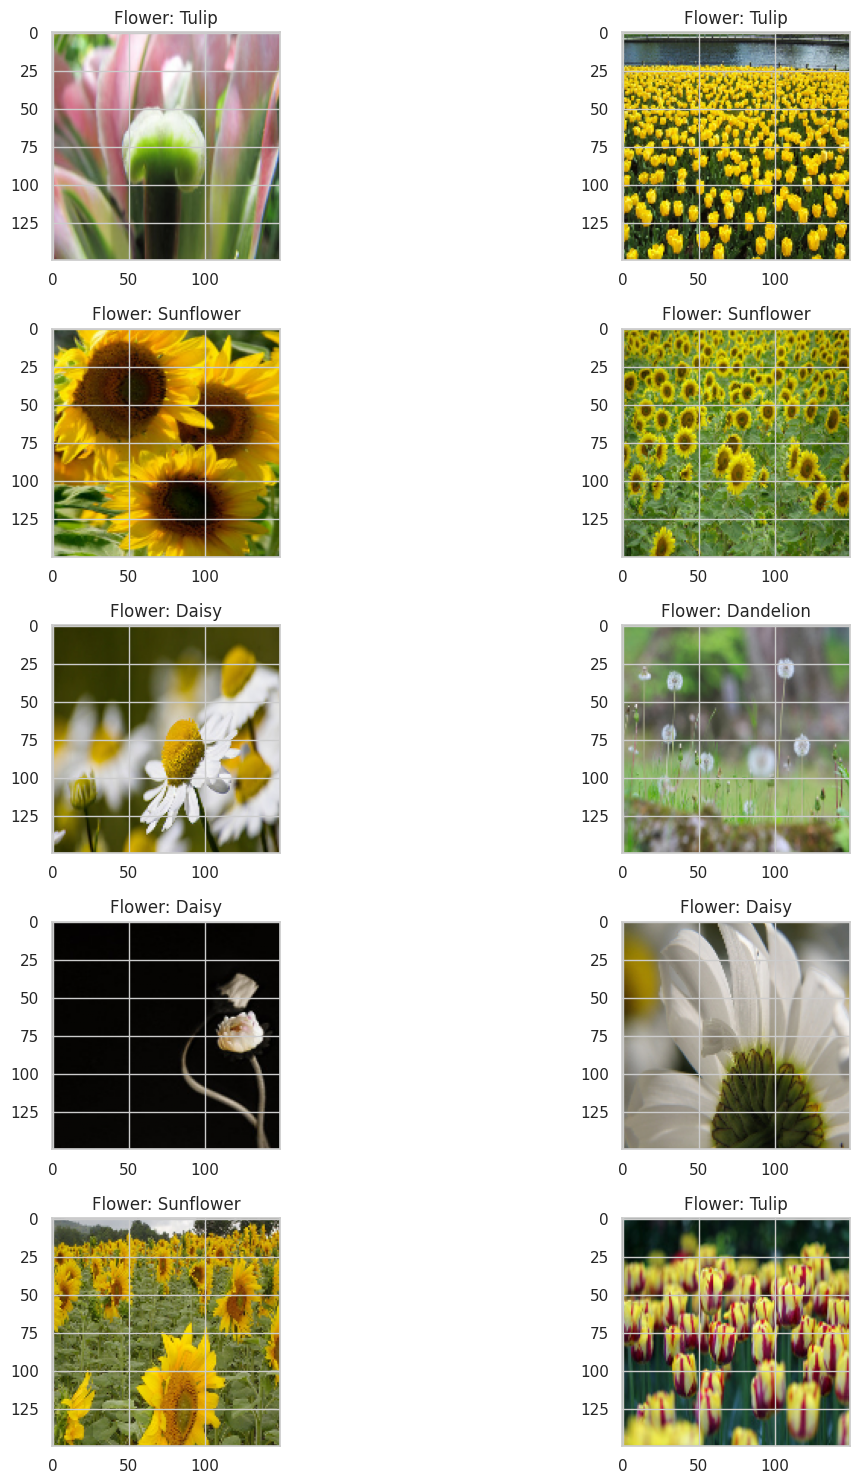

In [47]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])

plt.tight_layout()

## 2.3 ) Címkekódolás az Y tömbben (pl. Százszorszép->0, Rózsa->1 stb...), majd One Hot Encoding

In [48]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,5)
X=np.array(X)
X=X/255

## 2.4 ) Felosztás képzési és validálási halmazokra

In [49]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

## 2.5 ) A véletlen magok beállítása

In [50]:
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

## 3 ) Modellezés

## 3.1 ) A ConvNet modell felépítése

In [51]:
# # modelling starts using a CNN.
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dense(5, activation = "softmax"))

## 3.2 ) LR lágyító használata

In [52]:
batch_size=128
epochs=20

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

## 3.3 ) Adatbővítés a túlillesztés megakadályozására

In [53]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # a bemeneti átlagot 0-ra állítja az adathalmazon
        samplewise_center=False,  # minden minta átlagát 0-ra állítsuk
        featurewise_std_normalization=False,  # a bemenetek osztása az adatállomány std értékével
        samplewise_std_normalization=False,  # osszuk el az egyes bemeneteket az std
        zca_whitening=False,  # alkalmazni ZCA fehérítés
        rotation_range=10,  # véletlenszerűen forgatja a képeket a (0 és 180 fok közötti) tartományban.
        zoom_range = 0.1, # Kép véletlenszerű nagyítása
        width_shift_range=0.2,  # a képek véletlenszerű vízszintes eltolása (a teljes szélesség töredéke)
        height_shift_range=0.2,  # a képek véletlenszerű függőleges eltolása (a teljes magasság töredéke)
        horizontal_flip=True,  # véletlenszerűen flip képek
        vertical_flip=False)  # véletlenszerűen flip képek

datagen.fit(x_train)

## 3.4 ) A Keras modell fordítása és összefoglaló

In [54]:
model.compile(optimizer=Adam(learning_rate=0.1),loss='categorical_crossentropy',metrics=['accuracy'])

In [55]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 150, 150, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    10,617,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,713,157 (40.87 MB)

 Trainable params: 10,713,157 (40.87 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
# visualkeras.layered_view(model, legend=True)
visualkeras.layered_view(model, legend=True)

AttributeError: 'Conv2D' object has no attribute 'output_shape'

## 3.5 ) Illesztés a gyakorlóhalmazon és előrejelzések készítése a validációs halmazon

In [65]:
History = model.fit(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)
# model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Epoch 1/20


2024-03-25 17:45:21.899533: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 368640000 exceeds 10% of free system memory.
2024-03-25 17:45:22.797741: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 184320000 exceeds 10% of free system memory.
2024-03-25 17:45:24.414572: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 184320000 exceeds 10% of free system memory.
2024-03-25 17:45:25.053369: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 184320000 exceeds 10% of free system memory.
2024-03-25 17:45:25.053428: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 368640000 exceeds 10% of free system memory.


25/25 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.2030 - loss: 699.6905 - val_accuracy: 0.2306 - val_loss: 1.6217
Epoch 2/20
 1/25 ━━━━━━━━━━━━━━━━━━━━ 1:03 3s/step - accuracy: 0.2266 - loss: 1.6284

2024-03-25 17:46:43.154580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 431ms/step - accuracy: 0.2266 - loss: 0.8468 - val_accuracy: 0.2306 - val_loss: 1.6148
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.2523 - loss: 1.6046 - val_accuracy: 0.2185 - val_loss: 1.6311
Epoch 4/20
 1/25 ━━━━━━━━━━━━━━━━━━━━ 18s 783ms/step - accuracy: 0.3784 - loss: 1.5603

2024-03-25 17:48:18.856227: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step - accuracy: 0.3784 - loss: 0.8114 - val_accuracy: 0.2185 - val_loss: 1.6258
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.2259 - loss: 1.6034 - val_accuracy: 0.2306 - val_loss: 1.6084
Epoch 6/20
 1/25 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.2812 - loss: 1.5923

2024-03-25 17:49:45.877174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 294ms/step - accuracy: 0.2812 - loss: 0.8280 - val_accuracy: 0.2306 - val_loss: 1.6079
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - accuracy: 0.2539 - loss: 1.5997 - val_accuracy: 0.2306 - val_loss: 1.6087
Epoch 8/20
 1/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.1797 - loss: 1.6116

2024-03-25 17:51:13.276586: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 231ms/step - accuracy: 0.1797 - loss: 0.8380 - val_accuracy: 0.2306 - val_loss: 1.6096
Epoch 9/20


2024-03-25 17:51:46.940563: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1 of 8
2024-03-25 17:51:51.016751: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


25/25 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.2608 - loss: 1.5970 - val_accuracy: 0.2185 - val_loss: 1.6135
Epoch 10/20
 1/25 ━━━━━━━━━━━━━━━━━━━━ 1:01 3s/step - accuracy: 0.2891 - loss: 1.5780

2024-03-25 17:53:04.569418: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 427ms/step - accuracy: 0.2891 - loss: 0.8206 - val_accuracy: 0.2185 - val_loss: 1.6158
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.2539 - loss: 1.6012 - val_accuracy: 0.2306 - val_loss: 1.6087
Epoch 12/20
 1/25 ━━━━━━━━━━━━━━━━━━━━ 1:08 3s/step - accuracy: 0.2344 - loss: 1.6015

2024-03-25 17:54:32.553034: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 427ms/step - accuracy: 0.2344 - loss: 0.8328 - val_accuracy: 0.2306 - val_loss: 1.6085
Epoch 13/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.2480 - loss: 1.5976 - val_accuracy: 0.2306 - val_loss: 1.6068
Epoch 14/20
 1/25 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.2266 - loss: 1.6098

2024-03-25 17:56:06.880872: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 227ms/step - accuracy: 0.2266 - loss: 0.8371 - val_accuracy: 0.2306 - val_loss: 1.6074
Epoch 15/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - accuracy: 0.2429 - loss: 1.5969 - val_accuracy: 0.2306 - val_loss: 1.6070
Epoch 16/20
 1/25 ━━━━━━━━━━━━━━━━━━━━ 1:00 3s/step - accuracy: 0.2422 - loss: 1.6041

2024-03-25 17:57:32.772419: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 227ms/step - accuracy: 0.2422 - loss: 0.8341 - val_accuracy: 0.2306 - val_loss: 1.6068
Epoch 17/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 133s 3s/step - accuracy: 0.2483 - loss: 1.5974 - val_accuracy: 0.2185 - val_loss: 1.6071
Epoch 18/20
 1/25 ━━━━━━━━━━━━━━━━━━━━ 1:00 3s/step - accuracy: 0.2422 - loss: 1.5988

2024-03-25 17:59:53.680847: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 427ms/step - accuracy: 0.2422 - loss: 0.8314 - val_accuracy: 0.2185 - val_loss: 1.6076
Epoch 19/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.2445 - loss: 1.5945 - val_accuracy: 0.2306 - val_loss: 1.6076
Epoch 20/20
 1/25 ━━━━━━━━━━━━━━━━━━━━ 1:00 3s/step - accuracy: 0.2422 - loss: 1.6215

2024-03-25 18:01:19.903966: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 225ms/step - accuracy: 0.2422 - loss: 0.8432 - val_accuracy: 0.2306 - val_loss: 1.6063


## 4 ) A modell teljesítményének értékelése

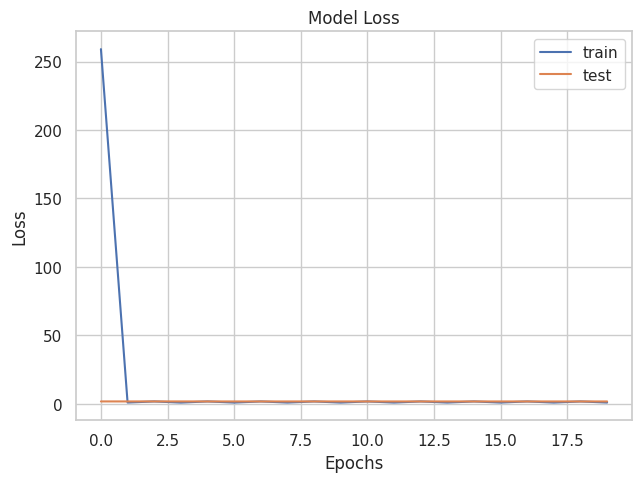

In [67]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [68]:
print(History.history)

{'accuracy': [0.22483113408088684, 0.2265625, 0.2421875, 0.37837839126586914, 0.22933419048786163, 0.28125, 0.2454165369272232, 0.1796875, 0.2534576952457428, 0.2890625, 0.2537793517112732, 0.234375, 0.23994854092597961, 0.2265625, 0.23190736770629883, 0.2421875, 0.2467031180858612, 0.2421875, 0.244129940867424, 0.2421875], 'loss': [259.0955505371094, 0.8141999244689941, 1.6056945323944092, 0.7801586985588074, 1.6030220985412598, 0.796166718006134, 1.5988186597824097, 0.8058063983917236, 1.5980355739593506, 0.7889949083328247, 1.6008615493774414, 0.8007631301879883, 1.5998642444610596, 0.8048769235610962, 1.5981833934783936, 0.8020597100257874, 1.5980865955352783, 0.7993913888931274, 1.5966546535491943, 0.8107366561889648], 'val_accuracy': [0.23055554926395416, 0.23055554926395416, 0.21851852536201477, 0.21851852536201477, 0.23055554926395416, 0.23055554926395416, 0.23055554926395416, 0.23055554926395416, 0.21851852536201477, 0.21851852536201477, 0.23055554926395416, 0.2305555492639541

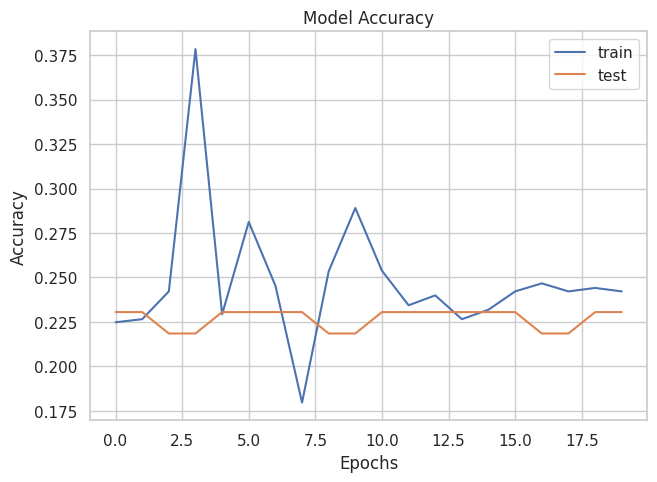

In [69]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

## 5 ) Előrejelzések vizualizálása a validációs készleten

In [70]:
# getting predictions on val set.
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 164ms/step


In [71]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

#### HELYESEN OSZTÁLYOZOTT VIRÁGKÉPEK

In [72]:
print(le.inverse_transform([pred_digits[prop_class[0]]]))

['Dandelion']


In [73]:
print([y_test[prop_class[0]]])

[array([0., 1., 0., 0., 0.])]


In [74]:
print(le.inverse_transform(np.argmax([y_test[prop_class[0]]], axis=1)))

['Dandelion']


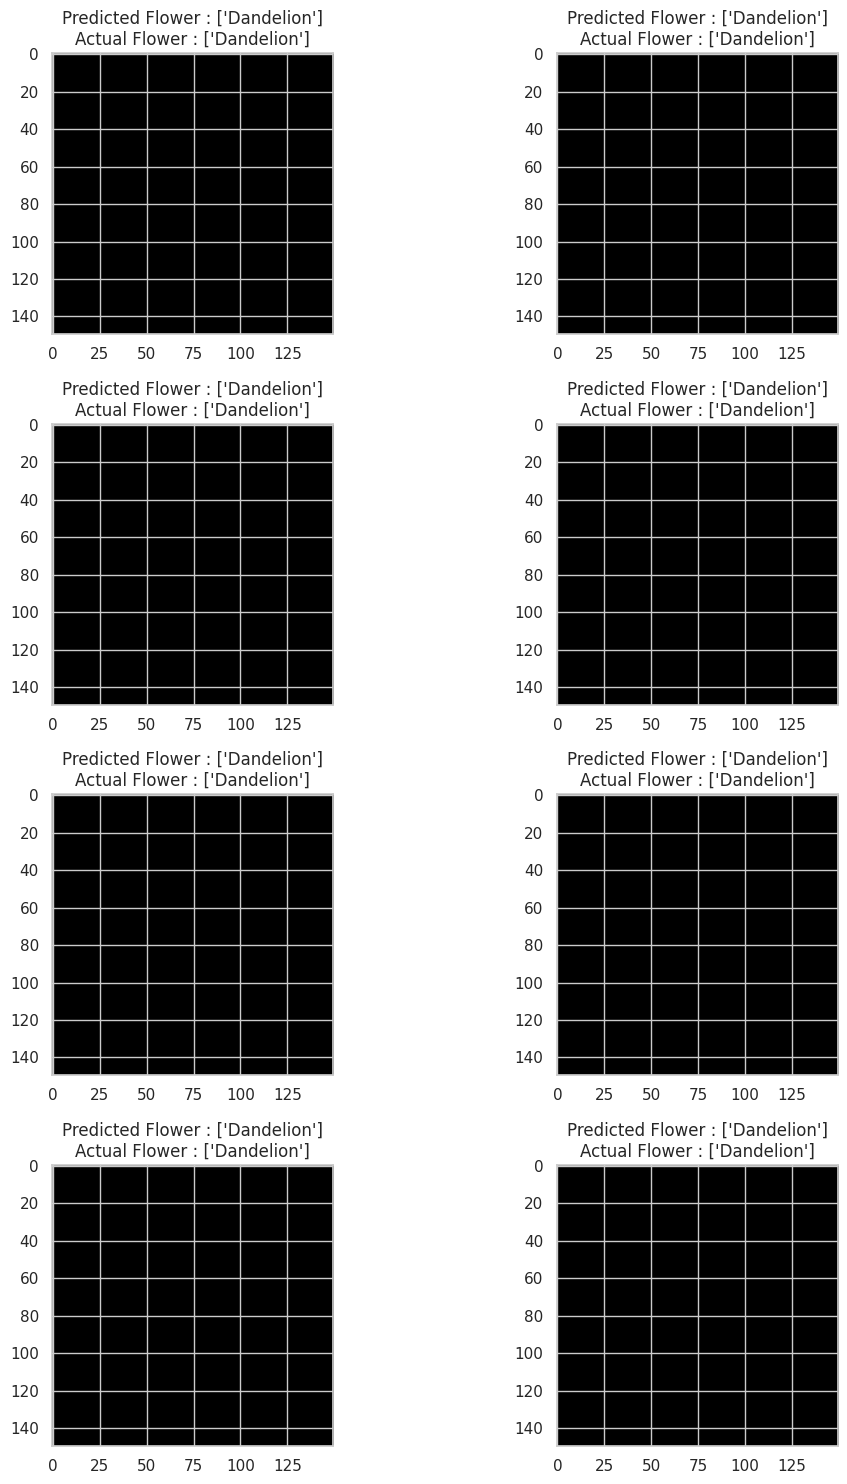

In [75]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[prop_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform(np.argmax([y_test[prop_class[count]]], axis=1))))
        plt.tight_layout()
        count+=1

#### TÉVESEN BESOROLT KÉPEK VIRÁGOKRÓL

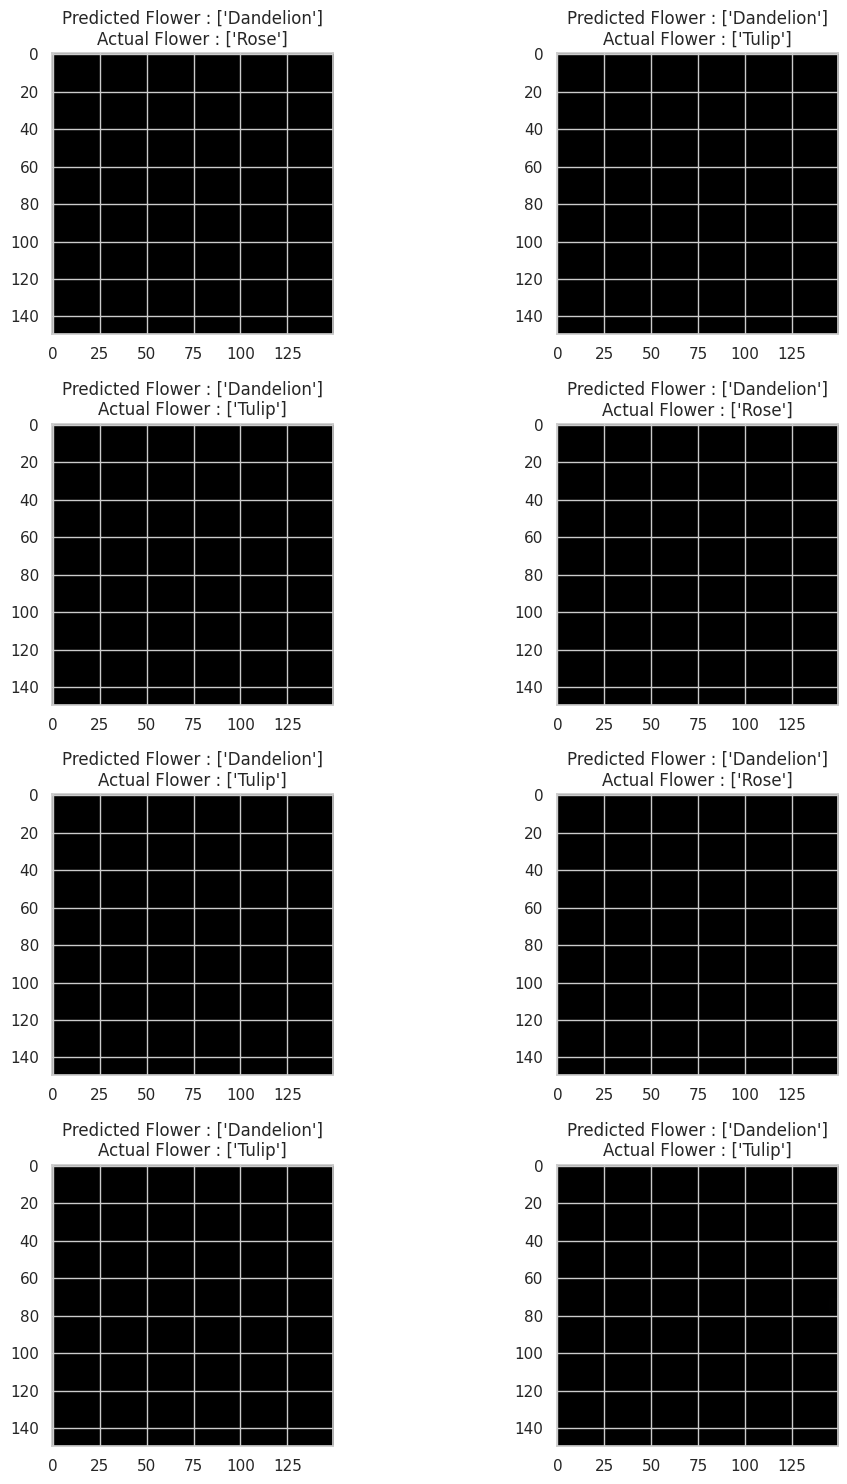

In [76]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[mis_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform(np.argmax([y_test[mis_class[count]]], axis=1))))
        plt.tight_layout()
        count+=1

# Túltanítás

In [77]:
import tensorflow as tf

cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[150, 150, 3]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
cnn.add(tf.keras.layers.Dense(units=5, activation='softmax'))

cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [78]:
cnn.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 72, 72, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,319,333 (20.29 MB)

 Trainable params: 5,319,333 (20.29 MB)

 Non-trainable params: 0 (0.00 B)

In [79]:
visualkeras.layered_view(model, legend=True)

AttributeError: 'Conv2D' object has no attribute 'output_shape'

In [80]:
history = cnn.fit(x_train,y_train, validation_data = (x_test,y_test), epochs=30, verbose=1)

Epoch 1/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 40s 369ms/step - accuracy: 0.2566 - loss: 1.6026 - val_accuracy: 0.2306 - val_loss: 1.6105
Epoch 2/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 39s 384ms/step - accuracy: 0.2515 - loss: 1.5959 - val_accuracy: 0.2306 - val_loss: 1.6060
Epoch 3/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 34s 330ms/step - accuracy: 0.2566 - loss: 1.5947 - val_accuracy: 0.2306 - val_loss: 1.6070
Epoch 4/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 43s 427ms/step - accuracy: 0.2566 - loss: 1.5934 - val_accuracy: 0.2306 - val_loss: 1.6070
Epoch 5/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 74s 351ms/step - accuracy: 0.2566 - loss: 1.5932 - val_accuracy: 0.2306 - val_loss: 1.6070
Epoch 6/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 39s 328ms/step - accuracy: 0.2566 - loss: 1.5932 - val_accuracy: 0.2306 - val_loss: 1.6070
Epoch 7/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 44s 362ms/step - accuracy: 0.2566 - loss: 1.5932 - val_accuracy: 0.2306 - val_loss: 1.6070
Epoch 8/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 38s 335ms/step - accuracy: 0.2566 - loss: 1

KeyboardInterrupt: 

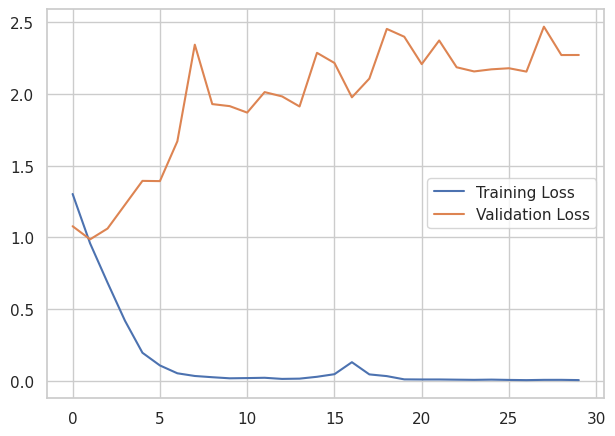

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

# Plot the loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
pred = cnn.predict(x_test)
pred=np.argmax(pred,axis=1)
y_test_argmax = np.argmax(y_test,axis=1)

34/34 [==============================] - 0s 13ms/step


In [ ]:
clf_report = pd.DataFrame(classification_report(y_test_argmax, pred, output_dict=True))
print("Result:\n================================================")
print(f"Accuracy Score: {accuracy_score(y_test_argmax, pred) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{clf_report}")
print("_______________________________________________")
print(f"Confusion Matrix: \n {confusion_matrix(y_test_argmax, pred)}\n")

Result:
Accuracy Score: 61.11%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1           2           3           4  \
precision    0.586957    0.603896    0.564935    0.728205    0.575439   
recall       0.393204    0.746988    0.462766    0.706468    0.694915   
f1-score     0.470930    0.667864    0.508772    0.717172    0.629559   
support    206.000000  249.000000  188.000000  201.000000  236.000000   

           accuracy    macro avg  weighted avg  
precision  0.611111     0.611886      0.610800  
recall     0.611111     0.600868      0.611111  
f1-score   0.611111     0.598859      0.603413  
support    0.611111  1080.000000   1080.000000  
_______________________________________________
Confusion Matrix: 
 [[ 81  60  25  14  26]
 [ 20 186   1  19  23]
 [ 18  17  87   8  58]
 [ 10  29   6 142  14]
 [  9  16  35  12 164]]



In [ ]:
def perf_measure(y_test, y_pred):
    CM = confusion_matrix(y_test, y_pred)

    for i in range(5):
        #5 osztaly a ciklus alapjan
        print(str(le.inverse_transform([i]))," osztaly: " ,i+1)
        TP = CM[i][i]
        FP = CM[i,:].sum() - TP
        FN = CM[:,i].sum() - TP
        TN = CM[:,:].sum() - TP - FP - FN

        # Sensitivity, hit rate, recall, or true positive rate
        TPR = TP/(TP+FN)

        # Specificity or true negative rate
        TNR = TN/(TN+FP)

        # PPV positive predictive value
        PPV = TP/(TP+FP)

        # NPV negative predictive value
        NPV = TN/(TN+FN)

        #Accuracy
        ACC = (TP+TN)/(TP+FP+FN+TN)

        #Dice score
        DS = (2*TP)/((2*TP)+FP+FN)

        print("True positive :", TP)
        print("True negative :", TN)
        print("False positive :", FP)
        print("False negative :", FN, '\n')

        print("True positive rate :", TPR)
        print("True negative rate :", TNR)
        print("Positive predictive value :", PPV)
        print("Negative predictive value :", NPV)
        print("Accuracy :", ACC)
        print("Dice score :", DS, '\n')

In [ ]:
perf_measure(y_test_argmax, pred)

['Daisy']  osztaly:  1
True positive : 81
True negative : 817
False positive : 125
False negative : 57 

True positive rate : 0.5869565217391305
True negative rate : 0.8673036093418259
Positive predictive value : 0.3932038834951456
Negative predictive value : 0.9347826086956522
Accuracy : 0.8314814814814815
Dice score : 0.47093023255813954 

['Dandelion']  osztaly:  2
True positive : 186
True negative : 709
False positive : 63
False negative : 122 

True positive rate : 0.6038961038961039
True negative rate : 0.9183937823834197
Positive predictive value : 0.7469879518072289
Negative predictive value : 0.8531889290012034
Accuracy : 0.8287037037037037
Dice score : 0.6678635547576302 

['Rose']  osztaly:  3
True positive : 87
True negative : 825
False positive : 101
False negative : 67 

True positive rate : 0.564935064935065
True negative rate : 0.8909287257019438
Positive predictive value : 0.4627659574468085
Negative predictive value : 0.9248878923766816
Accuracy : 0.8444444444444444
D

## ***Megoldandó feladatok*** ⌨
Válaszolj a kérdésekre és old meg a feladatokat:
1.   Fejleszd a modellt, hogy jobb eredményeket kapj, 23 és 61-től
2.   Próbáld ki, hogy a küldönbség az AVG és a MAX pooling között?
3.   Próbáld ki a DropOut layert. Milyen szerepe van? Miben segít?
4.   Magyarázd el a lenti kódot részletesen, melyik paraméter mit csinál?


```
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
```

5.   Mi a stride szerepe?


```
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
```




